In [1]:
from glob import glob
import numpy as np
import pandas as pd

Merge all the relevant files

In [2]:
data_files = glob("./data/*.csv")
users = np.unique([
  df.split("_")[0].split("/")[-1] for df in data_files
])

print(f"Users in the study: {len(users)}")

Users in the study: 52


In [3]:
def extract_ratings(name):
  file = pd.read_csv(name, header=None).transpose()
  ratings = []
  user_id = file.iloc[1, 1]

  for idx, row in file.iloc[2:].iterrows():
    sentence, method = eval(row[0])
    if "chatgpt" in method.lower():
      method, fitness_fn = "chatgpt", ""
    else:
      splitted = method.split("_")
      if len(splitted) == 7:
        _, _, _, _, method, _, fitness_fn = splitted
      elif len(splitted) == 5:
        _, _, _, method, fitness_fn = splitted
      elif len(splitted) == 9:
        _, _, _, _, method_1, _, method_2, method_3, fitness_fn = splitted
        method = f"{method_1}_{method_2}_{method_3}"
      
      if fitness_fn == "projec": fitness_fn = "project"

    rating = int(row[1])
    
    ratings.append((user_id, sentence, method, fitness_fn, rating))
  return ratings

In [4]:
def read_indicator(ind):
  ratings_fit_files = glob(f"data/*_{ind}.csv")
  df = pd.DataFrame(columns=["user_id", "sentence", "method", "fitness_fn", "rating"])

  for f in ratings_fit_files:
    content = extract_ratings(f)
    for c in content:
      df.loc[len(df)] = c

  return df

# Stats

In [30]:
# mean rating for each method on the fit criteria
fit = read_indicator("fit")
fit["indicator"] = "fitness"
original = read_indicator("original")
original["indicator"] = "originality"
understand = read_indicator("understand")
understand["indicator"] = "understandability"
df = pd.concat([fit, original, understand])

df["A"] = df.sentence.apply(lambda x: x.split(" is the")[0].strip() if "is the" in x else x.split(" was the")[0].strip())
df["B"] = df.sentence.apply(lambda x: x.split("the ")[1].split(" of")[0].strip())

for f in glob("data/*knows_ents.csv"):
  conf = pd.read_csv(f).transpose().iloc[1:].reset_index()

  scores_map = {
    "I know who that person is.": 2,
    "I have heard of the name but I cannot relate it to anything.": 1,
    "I have never heard of that name before.": 0
  }

  user_id = conf.iloc[0, 1]

  for idx, row in conf.iloc[1:].reset_index().iterrows():
    score = scores_map[row.iloc[2]]
    ent = row.iloc[1]
    
    df.loc[(df.user_id == user_id) & (df.A == ent), "conf_A"] = score
    df.loc[(df.user_id == user_id) & (df.B == ent), "conf_B"] = score

# stats

In [116]:
import collections
import matplotlib.pyplot as plt

method_map = {
  "transe_word2vec_concatenate": "TransE $\oplus$ word2vec",
  "transe": "TransE",
  "chatgpt": "ChatGPT"
}

In [96]:
df[df.rating == 0].groupby(["method", "fitness_fn"]).count().rating.to_numpy()

array([ 7, 12,  9,  7,  9, 10, 10])

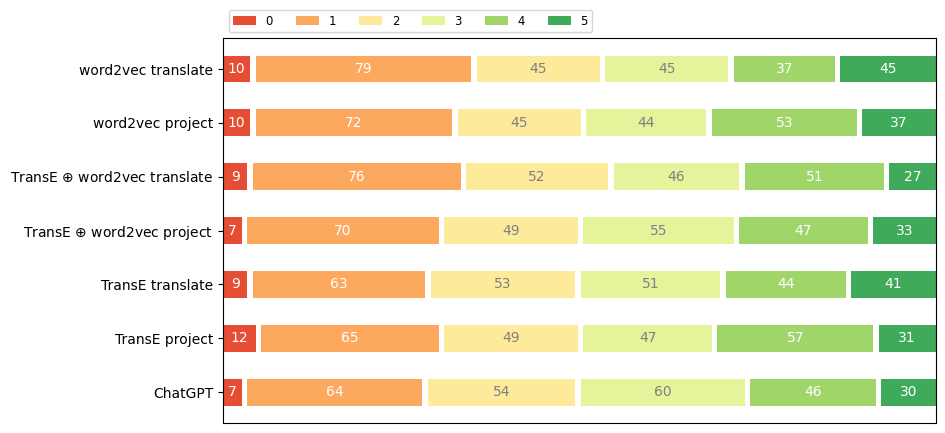

In [155]:
import numpy as np

dfg = df.groupby(["method", "fitness_fn"])
labels = [
    f"{method_map[m] if m in method_map else m} {fitness_fn if m != 'chatgpt' else ''}".strip()
    for m, fitness_fn in dfg.rating.mean().index
]
#data_cum = dfg.to_numpy()
category_colors = plt.colormaps['RdYlGn'](np.linspace(0.15, 0.85, 6))

fig, ax = plt.subplots(figsize=(9.2, 5))
#ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, dfg.count().rating.to_numpy()[0])

last_widths = None
for i, (colname, color) in enumerate(zip(labels, category_colors)):
    widths = df[df.rating == i].groupby(["method", "fitness_fn"]).count().rating.to_numpy()
    starts = np.zeros_like(widths) if last_widths is None else last_widths
    last_widths = starts + widths + 2

    rects = ax.barh(labels, widths, left=starts, height=0.5,
                    label=f"{i}", color=color)

    r, g, b, _ = color
    text_color = 'white' if r * g * b < 0.5 else 'grey'
    ax.bar_label(rects, label_type='center', color=text_color)

ax.legend(ncols=6, bbox_to_anchor=(0, 1), loc='lower left', fontsize='small')
fig.savefig("dist.png", dpi=300, bbox_inches = "tight")